<a href="https://colab.research.google.com/github/sudhirshahu51/RAG/blob/main/3_Building_an_agent_reasoning_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%writefile requirements.txt

llama-index==0.10.27
llama-index-llms-text-generation-inference
llama-index-llms-huggingface
llama-index-llms-huggingface-api
sentence-transformers #for embedding model
llama-index-embeddings-huggingface
llama-index-embeddings-instructor

Writing requirements.txt


In [4]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.6/915.6 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/

**Login for HuggingFace API for LLM**

In [6]:
import textwrap
from typing import List, Optional
from llama_index.core import Settings
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.llms.huggingface_api import HuggingFaceInferenceAPI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.tools import FunctionTool
from llama_index.core import SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import VectorStoreIndex
from llama_index.core.vector_stores import MetadataFilters
from llama_index.core import SummaryIndex
from llama_index.core.tools import QueryEngineTool
from llama_index.core.vector_stores import FilterCondition

In [10]:
import os
from google.colab import userdata
key = userdata.get('HUGGING_FACE')
os.environ['HUGGINGFACEHUB_API_TOKEN'] = key

In [2]:
# to make async work well with jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [11]:
#from llama_index.llms.openai import OpenAI
llm = HuggingFaceInferenceAPI(
                          model_name="HuggingFaceH4/zephyr-7b-alpha",
                          task='complete',
                          token=key)
#Embedding Model and LLM
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5") # Try using Stella too dunzhang/stella_en_400M_v5 https://huggingface.co/spaces/mteb/leaderboard

In [12]:
Settings.llm = llm
Settings.embed_model = embed_model

**Setup the Query Tools**

In [13]:
def get_doc_tools(
    file_path: str,
    name: str,
) -> str:
    """Get vector query and summary query tools from a document."""

    # load documents
    documents = SimpleDirectoryReader(input_files=[file_path]).load_data()
    splitter = SentenceSplitter(chunk_size=1024)
    nodes = splitter.get_nodes_from_documents(documents)
    vector_index = VectorStoreIndex(nodes)

    def vector_query(
        query: str,
        page_numbers: Optional[List[str]] = None
    ) -> str:
        """Use to answer questions over the MetaGPT paper.

        Useful if you have specific questions over the MetaGPT paper.
        Always leave page_numbers as None UNLESS there is a specific page you want to search for.

        Args:
            query (str): the string query to be embedded.
            page_numbers (Optional[List[str]]): Filter by set of pages. Leave as NONE
                if we want to perform a vector search
                over all pages. Otherwise, filter by the set of specified pages.

        """

        page_numbers = page_numbers or []
        metadata_dicts = [
            {"key": "page_label", "value": p} for p in page_numbers
        ]

        query_engine = vector_index.as_query_engine(
            similarity_top_k=2,
            filters=MetadataFilters.from_dicts(
                metadata_dicts,
                condition=FilterCondition.OR
            )
        )
        response = query_engine.query(query)
        return response


    vector_query_tool = FunctionTool.from_defaults(
        name=f"vector_tool_{name}",
        fn=vector_query
    )

    summary_index = SummaryIndex(nodes)
    summary_query_engine = summary_index.as_query_engine(
        response_mode="tree_summarize",
        use_async=True,
    )
    summary_tool = QueryEngineTool.from_defaults(
        name=f"summary_tool_{name}",
        query_engine=summary_query_engine,
        description=(
            "Use ONLY IF you want to get a holistic summary of MetaGPT. "
            "Do NOT use if you have specific questions over MetaGPT."
        ),
    )

    return vector_query_tool, summary_tool

In [15]:
path = '/content/drive/MyDrive/Colab Notebooks/Data/metagpt.pdf'
vector_tool, summary_tool = get_doc_tools(path , "metagpt")

In LlamaIndex, agent contains two main components.

* AgentRunner: Overall task dispatcher, which is responsible for creating and orchestrating tasks, and return the final response to the user.
* AgentWorker: Executing the next step

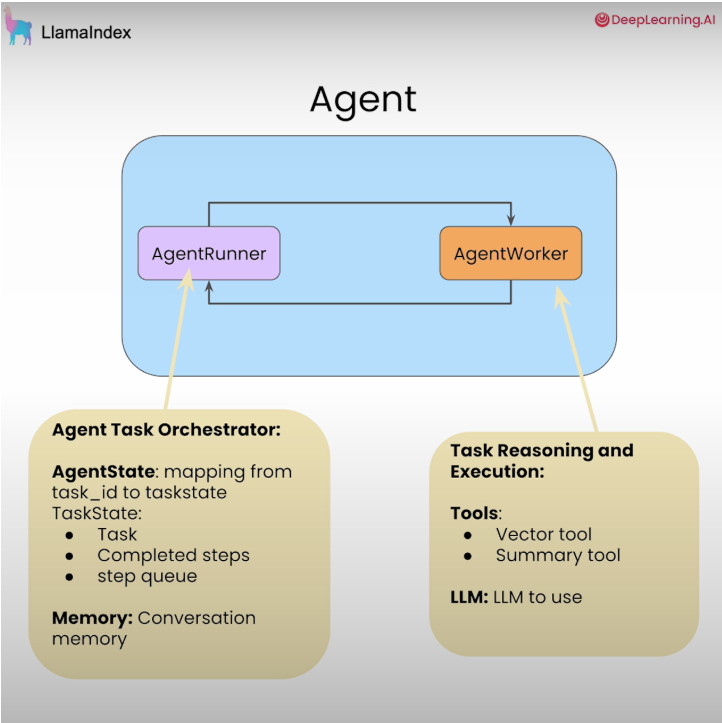

In [17]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

# define agentworker and passing two tools to the worker
agent_worker =  FunctionCallingAgentWorker.from_tools(
                [vector_tool, summary_tool],
                llm =  llm,
                verbose = True
)

#Agentrunner offers the interface for us to query the agent
agent_runner = AgentRunner(agent_worker, verbose = True)

AttributeError: 'HuggingFaceInferenceAPI' object has no attribute 'model'

In [ ]:
# resolve the above later for function calling.